In [83]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [84]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS3540/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CS3540-Assignments', 'CS3540-CodeSessions', 'prisondata.csv', 'prisondata.gsheet', 'Prison-Ashley.ipynb', 'unemployment.csv', 'crime_and_incarceration_by_state.csv', 'crime_and_incarceration_by_state.gsheet', 'unemployment.gsheet', 'Untitled0.ipynb', 'CS3540-Final-Project-G12']


In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# import needed libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
# Helper libraries

print(tf.__version__)

2.19.0


In [86]:
data_path = GOOGLE_DRIVE_PATH + '/CS3540-Final-Project-G12/New Attempt Dataset Options'
print(os.listdir(data_path))

['US CPI.csv', 'US_inflation_rates.csv', 'df_unemployment_rates.csv', 'df_sex_unemployment_rates.csv', '2015-2025.csv', 'unemployment.csv', 'gold_monthly_csv.csv', 'gold_annual_csv.csv', 'avocado.csv', 'globalEconomicDataset.zip', 'foodPrices.zip', 'EconomnicData.zip', 'combined_unemployment.csv', 'economic_data.gsheet', 'oil_and_housing.csv']


# Unemployment Data

In [87]:
unemployment_sex_df = pd.read_csv(data_path + '/df_sex_unemployment_rates.csv')
unemployment_age_df = pd.read_csv(data_path + '/df_unemployment_rates.csv')
combined_unemployment = pd.concat([unemployment_age_df, unemployment_sex_df], axis=1)

print(combined_unemployment)

           date  overall_rate  age_16_17_rate  age_16_19_rate  age_18_19_rate  \
0    1948-01-01           3.4             9.4             8.5             8.3   
1    1948-02-01           3.8            13.1            10.0             8.2   
2    1948-03-01           4.0            13.0            10.5             8.9   
3    1948-04-01           3.9            11.2             9.5             8.6   
4    1948-05-01           3.5             6.5             7.0             7.9   
..          ...           ...             ...             ...             ...   
912  2024-01-01           3.7            10.0            10.6            10.8   
913  2024-02-01           3.9            12.5            12.5            12.2   
914  2024-03-01           3.8            14.1            12.6            11.5   
915  2024-04-01           3.9            12.6            11.7            11.3   
916  2024-05-01           4.0            13.6            12.3            11.4   

     age_16_24_rate  age_20

# CPI Data

In [88]:
CPI_df = pd.read_csv(data_path + "/US CPI.csv")
CPI_df["date"] = pd.to_datetime(CPI_df["Yearmon"])
CPI_df = CPI_df.drop(columns=["Yearmon"])
print(CPI_df)

          CPI       date
0       9.800 1913-01-01
1       9.800 1913-01-02
2       9.800 1913-01-03
3       9.800 1913-01-04
4       9.700 1913-01-05
...       ...        ...
1298  264.877 2021-01-03
1299  267.054 2021-01-04
1300  269.195 2021-01-05
1301  271.696 2021-01-06
1302  273.003 2021-01-07

[1303 rows x 2 columns]


# Housing and Oil

In [89]:
h_and_o_df = pd.read_csv(data_path + "/oil_and_housing.csv")
print(h_and_o_df)

           date  crude oil price   MSPUS
0    1963-01-01             2.97   17800
1    1963-02-01             2.97   17800
2    1963-03-01             2.97   17800
3    1963-04-01             2.97   18000
4    1963-05-01             2.97   18000
..          ...              ...     ...
698  2021-03-01            59.19  106000
699  2021-04-01            63.50  106000
700  2021-05-01            66.31  106000
701  2021-06-01            73.52  106000
702  2021-07-01            73.93  106000

[703 rows x 3 columns]


# Output data - calculate inflation rate

In [90]:
output_df = CPI_df.copy()
output_df["inflation_rate"] = (output_df["CPI"].pct_change() * 100)
output_df = output_df.drop(columns=["CPI"])
output_df = output_df.dropna()
print(output_df)

           date  inflation_rate
1    1913-01-02        0.000000
2    1913-01-03        0.000000
3    1913-01-04        0.000000
4    1913-01-05       -1.020408
5    1913-01-06        1.030928
...         ...             ...
1298 2021-01-03        0.708327
1299 2021-01-04        0.821891
1300 2021-01-05        0.801711
1301 2021-01-06        0.929066
1302 2021-01-07        0.481052

[1302 rows x 2 columns]


# Experiment 1 - ridge regression predicting inflation rate with just CPI

In [91]:
experiment_1 = pd.merge(output_df, CPI_df, on="date")
print(experiment_1)

           date  inflation_rate      CPI
0    1913-01-02        0.000000    9.800
1    1913-01-03        0.000000    9.800
2    1913-01-04        0.000000    9.800
3    1913-01-05       -1.020408    9.700
4    1913-01-06        1.030928    9.800
...         ...             ...      ...
1297 2021-01-03        0.708327  264.877
1298 2021-01-04        0.821891  267.054
1299 2021-01-05        0.801711  269.195
1300 2021-01-06        0.929066  271.696
1301 2021-01-07        0.481052  273.003

[1302 rows x 3 columns]


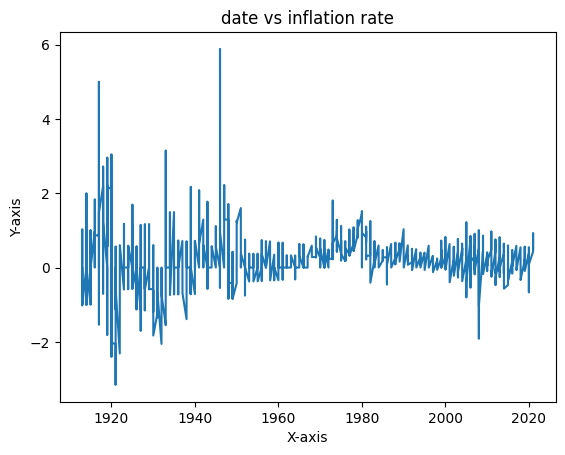

In [92]:
plt.plot(experiment_1["date"], experiment_1["inflation_rate"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs inflation rate')

plt.show()

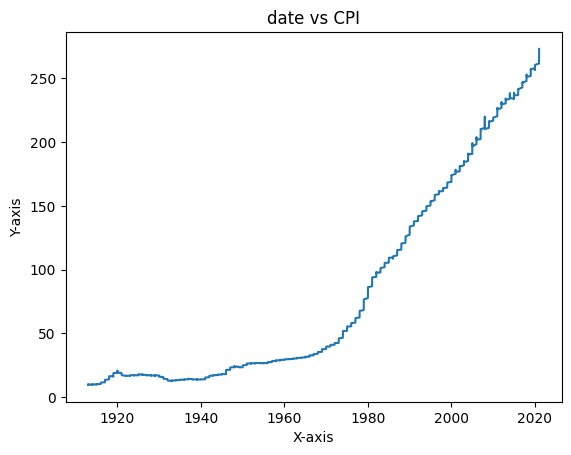

In [93]:
plt.plot(experiment_1["date"], experiment_1["CPI"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs CPI')

plt.show()

In [94]:
X = experiment_1[["CPI"]]
Y = experiment_1["inflation_rate"]
train_size = int(0.8 * len(experiment_1))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.4496582204451344
R² score: -0.43647052154860755
1.0


# Experiment 2 - adding lags and removing current CPI

In [95]:
experiment_2 = experiment_1.copy()
for lag in [1, 2, 3, 6, 12]:
    experiment_2[f"CPI_lag{lag}"] = experiment_2["CPI"].shift(lag)
experiment_2 = experiment_2.dropna()
print(experiment_2)

           date  inflation_rate      CPI  CPI_lag1  CPI_lag2  CPI_lag3  \
12   1914-01-02       -1.000000    9.900    10.000    10.000    10.100   
13   1914-01-03        0.000000    9.900     9.900    10.000    10.000   
14   1914-01-04       -1.010101    9.800     9.900     9.900    10.000   
15   1914-01-05        1.020408    9.900     9.800     9.900     9.900   
16   1914-01-06        0.000000    9.900     9.900     9.800     9.900   
...         ...             ...      ...       ...       ...       ...   
1297 2021-01-03        0.708327  264.877   263.014   261.582   260.474   
1298 2021-01-04        0.821891  267.054   264.877   263.014   261.582   
1299 2021-01-05        0.801711  269.195   267.054   264.877   263.014   
1300 2021-01-06        0.929066  271.696   269.195   267.054   264.877   
1301 2021-01-07        0.481052  273.003   271.696   269.195   267.054   

      CPI_lag6  CPI_lag12  
12       9.900      9.800  
13      10.000      9.800  
14      10.000      9.800  

In [96]:
X = experiment_2.drop(columns=["inflation_rate", "date", "CPI"])
Y = experiment_2["inflation_rate"]
train_size = int(0.8 * len(experiment_2))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.44752916105142554
R² score: -0.40897193985841773
1.0


# Experiment 3 - use differences between lags

In [97]:
experiment_3 = experiment_2.copy()
for lag in [1, 2, 3, 6, 12]:
    experiment_3[f"CPI_pct_lag{lag}"] = experiment_3["CPI"].pct_change(lag)
experiment_3 = experiment_3.dropna()
print(experiment_3)

           date  inflation_rate      CPI  CPI_lag1  CPI_lag2  CPI_lag3  \
24   1915-01-02       -0.990099   10.000    10.100    10.100    10.200   
25   1915-01-03       -1.000000    9.900    10.000    10.100    10.100   
26   1915-01-04        1.010101   10.000     9.900    10.000    10.100   
27   1915-01-05        1.000000   10.100    10.000     9.900    10.000   
28   1915-01-06        0.000000   10.100    10.100    10.000     9.900   
...         ...             ...      ...       ...       ...       ...   
1297 2021-01-03        0.708327  264.877   263.014   261.582   260.474   
1298 2021-01-04        0.821891  267.054   264.877   263.014   261.582   
1299 2021-01-05        0.801711  269.195   267.054   264.877   263.014   
1300 2021-01-06        0.929066  271.696   269.195   267.054   264.877   
1301 2021-01-07        0.481052  273.003   271.696   269.195   267.054   

      CPI_lag6  CPI_lag12  CPI_pct_lag1  CPI_pct_lag2  CPI_pct_lag3  \
24      10.200      9.900     -0.009901 

In [98]:
X = experiment_3[["CPI_pct_lag1", "CPI_pct_lag2", "CPI_pct_lag3", "CPI_pct_lag6", "CPI_pct_lag12"]]
Y = experiment_3["inflation_rate"]
train_size = int(0.8 * len(experiment_3))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.0006757975618265832
R² score: 0.9999967613004022
1.0


# Analysis of my findings

In [99]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_[0]
}).sort_values(by="coef", key=lambda s: np.abs(s), ascending=False)

print(coef_df.head(10))

         feature      coef
0   CPI_pct_lag1  0.686491
1   CPI_pct_lag2  0.686491
2   CPI_pct_lag3  0.686491
3   CPI_pct_lag6  0.686491
4  CPI_pct_lag12  0.686491


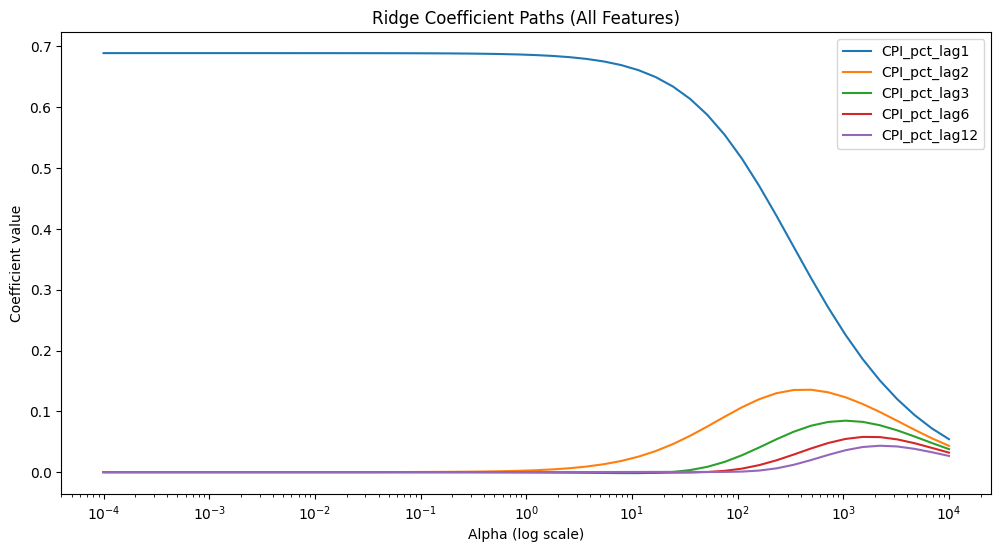

In [100]:
alphas = np.logspace(-4, 4, 50)
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (All Features)")
plt.legend()
plt.show()

In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(X_train.shape[1])]

print(vif_data)

         feature        VIF
0   CPI_pct_lag1   4.548480
1   CPI_pct_lag2  14.151266
2   CPI_pct_lag3  16.055835
3   CPI_pct_lag6  14.389165
4  CPI_pct_lag12   7.052180


# Adding unemployment features - most important features

In [102]:
unemp = combined_unemployment.copy()
unemp = unemp.dropna()
unemp_date = unemp.iloc[:,0]
unemp = unemp.drop(columns=["date"])
# Standardize
scaler = StandardScaler()
unemp_scaled = scaler.fit_transform(unemp)

pca = PCA(n_components=0.95)   # keep components that explain 95% variance
unemp_pca_array = pca.fit_transform(unemp_scaled)

# Convert PCA result to DataFrame
unemp_pca = pd.DataFrame(
    unemp_pca_array,
    columns=[f"PC{i+1}" for i in range(unemp_pca_array.shape[1])]
)

# Add the date column back
unemp_pca["date"] = unemp_date.reset_index(drop=True)
unemp_pca["date"] = pd.to_datetime(unemp_pca["date"])
print(unemp_pca.head())

print(f"Number of PCA components kept: {pca.n_components_}")
print("Explained variance ratio:", pca.explained_variance_ratio_)

        PC1       PC2       date
0  2.357488 -0.019653 1994-01-01
1  2.185185 -0.121239 1994-02-01
2  2.080075 -0.170672 1994-03-01
3  1.943146  1.077536 1994-04-01
4  0.907525  0.339616 1994-05-01
Number of PCA components kept: 2
Explained variance ratio: [0.92240663 0.0375804 ]


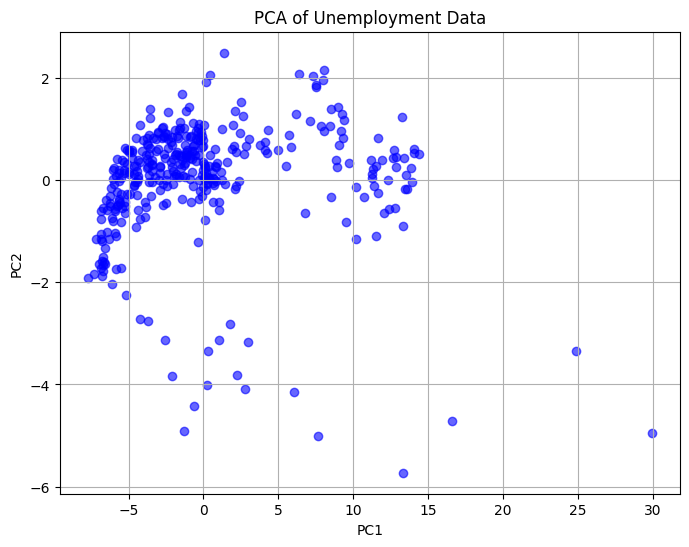

In [103]:
plt.figure(figsize=(8,6))
plt.scatter(unemp_pca["PC1"], unemp_pca["PC2"], c='blue', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Unemployment Data')
plt.grid(True)
plt.show()

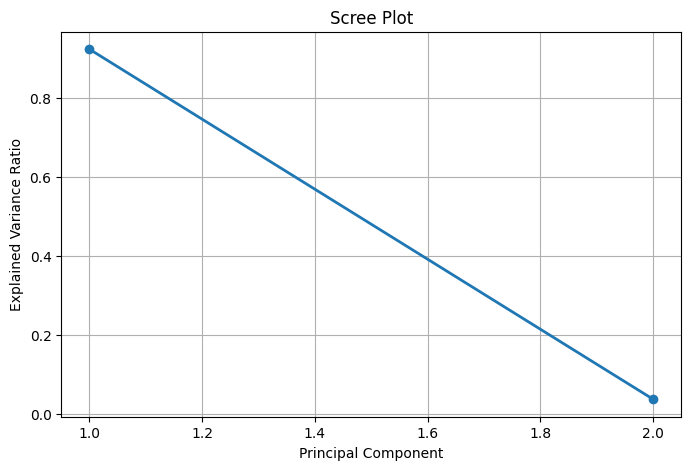

In [104]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

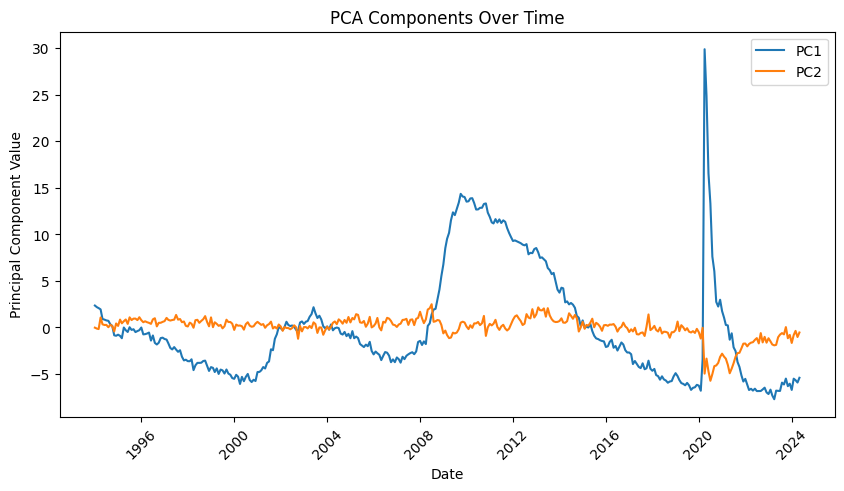

In [105]:
plt.figure(figsize=(10,5))
plt.plot(unemp_pca["date"], unemp_pca["PC1"], label="PC1")
plt.plot(unemp_pca["date"], unemp_pca["PC2"], label="PC2")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.title("PCA Components Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Experiment 4 - adding PCA'd unemployment features

In [106]:
experiment_4 = experiment_3.copy()
experiment_4 = pd.merge(experiment_4, unemp_pca, on="date")
print(experiment_4.head())
print(experiment_4.shape)

        date  inflation_rate    CPI  CPI_lag1  CPI_lag2  CPI_lag3  CPI_lag6  \
0 1994-01-01        0.274348  146.2     145.8     145.8     145.7     144.4   
1 1995-01-01        0.400802  150.3     149.7     149.7     149.5     148.4   
2 1996-01-01        0.586319  154.4     153.5     153.6     153.7     152.5   
3 1997-01-01        0.315259  159.1     158.6     158.6     158.3     157.0   
4 1998-01-01        0.185989  161.6     161.3     161.5     161.6     160.5   

   CPI_lag12  CPI_pct_lag1  CPI_pct_lag2  CPI_pct_lag3  CPI_pct_lag6  \
0      142.6      0.002743      0.002743      0.003432      0.012465   
1      146.2      0.004008      0.004008      0.005351      0.012803   
2      150.3      0.005863      0.005208      0.004554      0.012459   
3      154.4      0.003153      0.003153      0.005054      0.013376   
4      159.1      0.001860      0.000619      0.000000      0.006854   

   CPI_pct_lag12       PC1       PC2  
0       0.025245  2.357488 -0.019653  
1       0.0280

In [107]:
X = experiment_4[["CPI_pct_lag1", "CPI_pct_lag2", "CPI_pct_lag3", "CPI_pct_lag6", "CPI_pct_lag12", "PC1", "PC2"]]
Y = experiment_4["inflation_rate"]
train_size = int(0.8 * len(experiment_4))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.011907628524860027
R² score: 0.9944134115206209
1.0


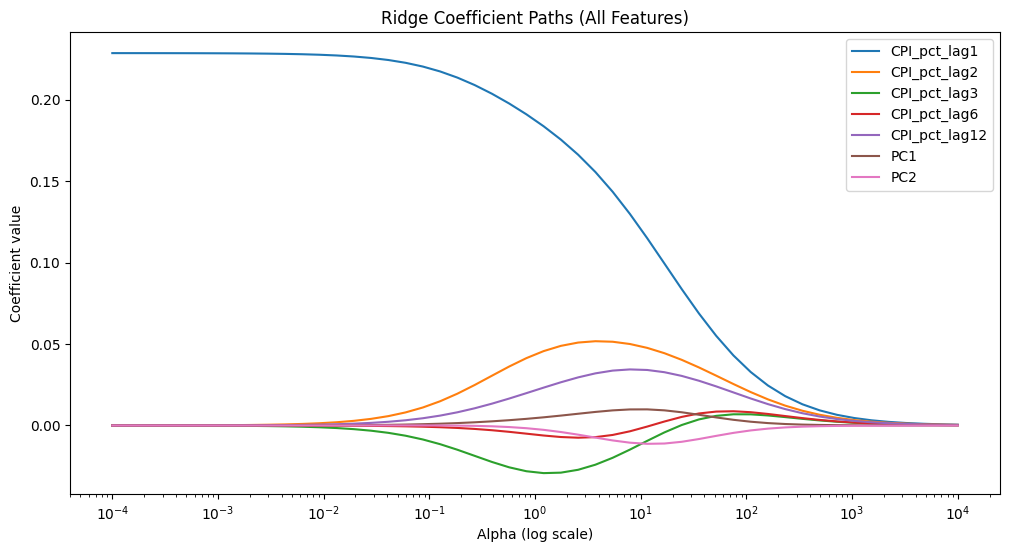

In [108]:
alphas = np.logspace(-4, 4, 50)
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (All Features)")
plt.legend()
plt.show()

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(X_train.shape[1])]

print(vif_data)

         feature        VIF
0   CPI_pct_lag1  35.263202
1   CPI_pct_lag2  29.288888
2   CPI_pct_lag3  18.623356
3   CPI_pct_lag6   6.430217
4  CPI_pct_lag12  16.362130
5            PC1   1.248253
6            PC2   2.092678


# adding housing and oil data
this will be added to the data without unemployment first

In [110]:
experiment_5 = experiment_3.copy()
# want to get the change in oil price - similar to the CPI values. And same with the MSPUS
h_and_o_df["oil_change"] = h_and_o_df["crude oil price"].pct_change()
h_and_o_df["hpi_change"] = h_and_o_df["MSPUS"].pct_change()
h_and_o_df = h_and_o_df.dropna()
# print(h_and_o_df.head())
h_and_o_df["date"] = pd.to_datetime(h_and_o_df["date"])
# print(experiment_5.head())
# print(h_and_o_df.head())
experiment_5_merged = pd.merge(experiment_5, h_and_o_df, on="date")
print(experiment_5_merged.head())
print(experiment_5_merged.shape)

        date  inflation_rate   CPI  CPI_lag1  CPI_lag2  CPI_lag3  CPI_lag6  \
0 1964-01-01        0.000000  30.9      30.9      30.8      30.8      30.7   
1 1965-01-01        0.000000  31.2      31.2      31.2      31.1      31.1   
2 1966-01-01        0.000000  31.8      31.8      31.7      31.7      31.6   
3 1967-01-01        0.000000  32.9      32.9      32.9      32.9      32.5   
4 1968-01-01        0.589971  34.1      33.9      33.8      33.7      33.4   

   CPI_lag12  CPI_pct_lag1  CPI_pct_lag2  CPI_pct_lag3  CPI_pct_lag6  \
0       30.4        0.0000      0.003247      0.003247      0.006515   
1       30.9        0.0000      0.000000      0.003215      0.003215   
2       31.2        0.0000      0.003155      0.003155      0.006329   
3       31.8        0.0000      0.000000      0.000000      0.012308   
4       32.9        0.0059      0.008876      0.011869      0.020958   

   CPI_pct_lag12  crude oil price  MSPUS  oil_change  hpi_change  
0       0.016447             2.

In [111]:
X = experiment_5_merged[["CPI_pct_lag1", "CPI_pct_lag2", "CPI_pct_lag3", "CPI_pct_lag6", "CPI_pct_lag12", "oil_change", "hpi_change"]]
Y = experiment_5_merged["inflation_rate"]
train_size = int(0.8 * len(experiment_5_merged))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.005636107851186266
R² score: 0.9995477945630697
1.0


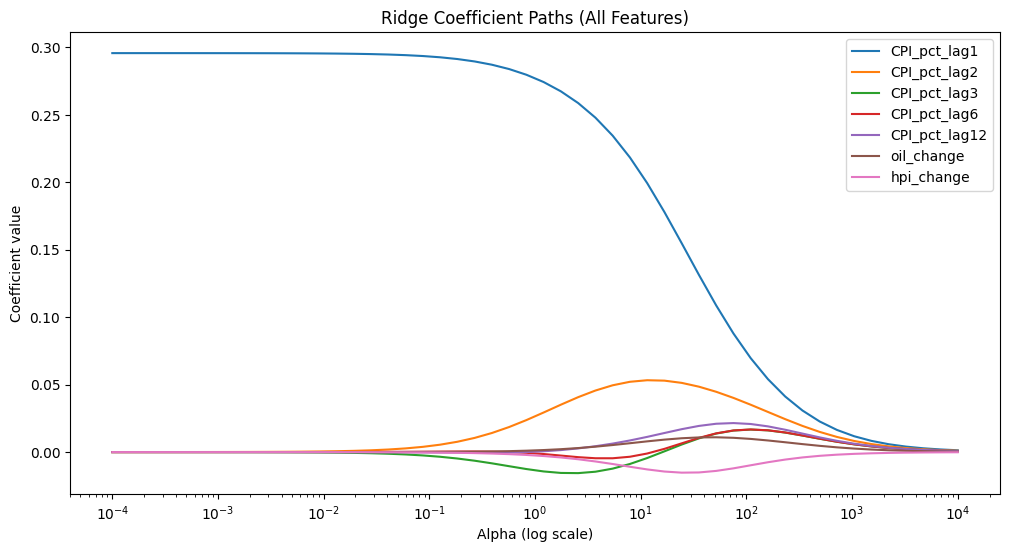

In [112]:
alphas = np.logspace(-4, 4, 50)
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (All Features)")
plt.legend()
plt.show()

In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(X_train.shape[1])]

print(vif_data)

         feature        VIF
0   CPI_pct_lag1   9.426320
1   CPI_pct_lag2  44.336531
2   CPI_pct_lag3  34.215383
3   CPI_pct_lag6  30.666516
4  CPI_pct_lag12  16.848203
5     oil_change   1.170829
6     hpi_change   1.234948


# Experiment 6 - ridge regression w/ all data

going to change unemployment rate to change in unemployment rate

In [114]:
experiment_6 = experiment_5_merged.copy()
unemp_pca["unemp_PC1_change"] = unemp_pca["PC1"].pct_change()
unemp_pca["unemp_PC2_change"] = unemp_pca["PC2"].pct_change()
unemp_pca = unemp_pca.dropna()
experiment_6_merged = pd.merge(experiment_6, unemp_pca, on="date")
print(experiment_6.head())
print(experiment_6.shape)
print(unemp_pca.head())
print(unemp_pca.shape)
print(experiment_6_merged.head())

        date  inflation_rate   CPI  CPI_lag1  CPI_lag2  CPI_lag3  CPI_lag6  \
0 1964-01-01        0.000000  30.9      30.9      30.8      30.8      30.7   
1 1965-01-01        0.000000  31.2      31.2      31.2      31.1      31.1   
2 1966-01-01        0.000000  31.8      31.8      31.7      31.7      31.6   
3 1967-01-01        0.000000  32.9      32.9      32.9      32.9      32.5   
4 1968-01-01        0.589971  34.1      33.9      33.8      33.7      33.4   

   CPI_lag12  CPI_pct_lag1  CPI_pct_lag2  CPI_pct_lag3  CPI_pct_lag6  \
0       30.4        0.0000      0.003247      0.003247      0.006515   
1       30.9        0.0000      0.000000      0.003215      0.003215   
2       31.2        0.0000      0.003155      0.003155      0.006329   
3       31.8        0.0000      0.000000      0.000000      0.012308   
4       32.9        0.0059      0.008876      0.011869      0.020958   

   CPI_pct_lag12  crude oil price  MSPUS  oil_change  hpi_change  
0       0.016447             2.

In [115]:
X = experiment_6_merged[["CPI_pct_lag1", "CPI_pct_lag2", "CPI_pct_lag3", "CPI_pct_lag6", "CPI_pct_lag12", "oil_change", "hpi_change", "unemp_PC1_change", "unemp_PC2_change"]]
Y = experiment_6_merged["inflation_rate"]
train_size = int(0.8 * len(experiment_6_merged))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 0.02158982891454558
R² score: 0.9816348479811504
1.0


In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(X_train.shape[1])]

print(vif_data)

            feature        VIF
0      CPI_pct_lag1  68.078892
1      CPI_pct_lag2  37.138226
2      CPI_pct_lag3  28.490793
3      CPI_pct_lag6   9.272193
4     CPI_pct_lag12  32.062688
5        oil_change   1.772341
6        hpi_change        NaN
7  unemp_PC1_change   5.058784
8  unemp_PC2_change   3.417176


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


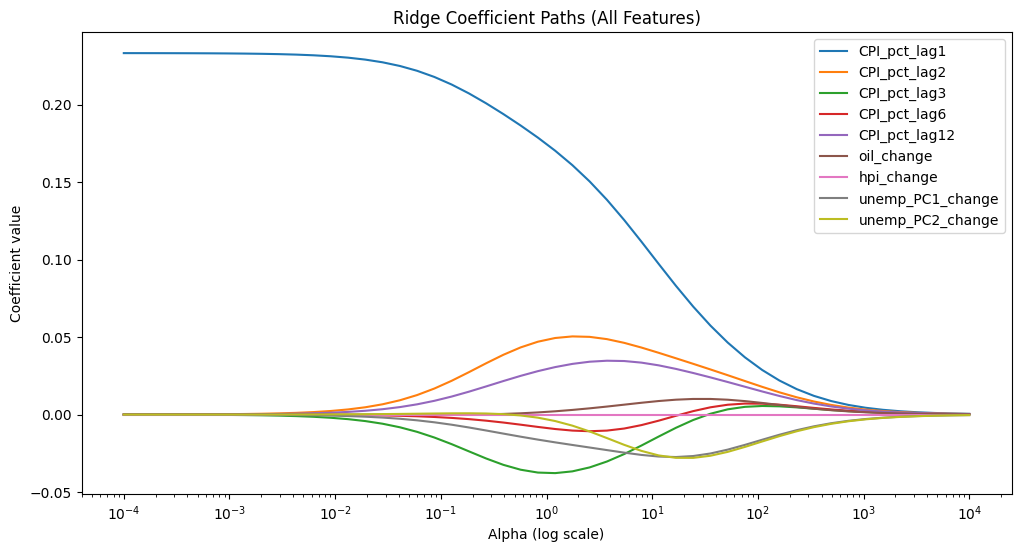

In [117]:
alphas = np.logspace(-4, 4, 50)
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(12, 6))
for i, col in enumerate(X.columns):
    plt.plot(alphas, coefs[:, i], label=col)

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient value")
plt.title("Ridge Coefficient Paths (All Features)")
plt.legend()
plt.show()